# Preamble and data import

In [1]:
!pip install uproot awkward vector

import numpy as np
import awkward as ak
import uproot
import vector
vector.register_awkward()
import os
import shutil
import zipfile
import tarfile
import urllib
import requests
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.0/365.0 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.4/879.4 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 638.7/638.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.3 MB/s eta 0:00:00


In [2]:
!pip install 'weaver-core>=0.4'
!pip install --force-reinstall numpy==2.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 342.7/342.7 kB 24.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: uproot
    Found existing installation: uproot 5.6.0
    Uninstalling uproot-5.6.0:
      Successfully uninstalled uproot-5.6.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy

In [3]:
def _download(url, fname, chunk_size=1024):
    '''https://gist.github.com/yanqd0/c13ed29e29432e3cf3e7c38467f42f51'''
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    with open(fname, 'wb') as file, tqdm(
        desc=fname,
        total=total,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

In [4]:
# Download the example file
example_file = 'JetClass_example_100k.root'
if not os.path.exists(example_file):
    _download('https://hqu.web.cern.ch/datasets/JetClass/example/JetClass_example_100k.root', example_file)

JetClass_example_100k.root: 100%|██████████| 130M/130M [00:08<00:00, 16.3MiB/s]


In [5]:
# Load the content from the file
tree = uproot.open(example_file)['tree']

In [6]:
# Display the content of the "tree"
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
part_px              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_py              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_pz              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_energy          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_deta            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dphi            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0val           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0err           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzval           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzerr           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_charge          | std::

part_*: JaggedArrays with features for each particle in a jet. These (and features constructed from them) are what we use for training in the Particle Transformer paper.

label_*: 1D numpy arrays one-hot truth labels for each jet. These are the target of the training.

jet_*: 1D numpy array with (high-level) features for each jet. These can also be used in the training, but since they are constructed from the particle-level features, it is not expected that they bring additional performance improvement.

aux_*: auxiliary truth information about the simulated particles for additional studies / interpretations. SHOULD NOT be used in the training of any classifier.

In [7]:
# Load all arrays in the tree
# Each array is a column of the table
table = tree.arrays()
# Arrays of a scalar type (bool/int/float) can be converted to a numpy array directly, e.g.
table['label_QCD'].to_numpy()
# Arrays of a vector type are loaded as a JaggedArray that has varying elements per row
table['part_px']
# A JaggedArray can be (zero-) padded to become a regular numpy array (see later)
# Construct a Lorentz 4-vector from the (px, py, pz, energy) arrays
p4 = vector.zip({'px': table['part_px'], 'py': table['part_py'], 'pz': table['part_pz'], 'energy': table['part_energy']})


In [8]:
def _pad(a, maxlen, value=0, dtype='float32'):
    if isinstance(a, np.ndarray) and a.ndim >= 2 and a.shape[1] == maxlen:
        return a
    elif isinstance(a, ak.Array):
        if a.ndim == 1:
            a = ak.unflatten(a, 1)
        a = ak.fill_none(ak.pad_none(a, maxlen, clip=True), value)
        return ak.values_astype(a, dtype)
    else:
        x = (np.ones((len(a), maxlen)) * value).astype(dtype)
        for idx, s in enumerate(a):
            if not len(s):
                continue
            trunc = s[:maxlen].astype(dtype)
            x[idx, :len(trunc)] = trunc
        return x

# Apply zero-padding and convert to a numpy array
_pad(p4.pt, maxlen=128).to_numpy()

array([[140.19296 ,  95.284584,  87.84807 , ...,   0.      ,   0.      ,
          0.      ],
       [244.67009 ,  62.332603,  45.159416, ...,   0.      ,   0.      ,
          0.      ],
       [143.15791 ,  91.48589 ,  25.372644, ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [157.69547 , 101.245445,  79.816284, ...,   0.      ,   0.      ,
          0.      ],
       [ 88.65814 ,  80.69194 ,  79.14036 , ...,   0.      ,   0.      ,
          0.      ],
       [171.13641 , 121.71926 ,  59.68036 , ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)

In [9]:
	def _clip(a, a_min, a_max):
    try:
        return np.clip(a, a_min, a_max)
    except ValueError:
        return ak.unflatten(np.clip(ak.flatten(a), a_min, a_max), ak.num(a))

In [10]:
def build_features_and_labels(tree, transform_features=True):

    # load arrays from the tree
    a = tree.arrays(filter_name=['part_*', 'jet_pt', 'jet_energy', 'label_*'])

    # compute new features
    a['part_mask'] = ak.ones_like(a['part_energy'])
    a['part_pt'] = np.hypot(a['part_px'], a['part_py'])
    a['part_pt_log'] = np.log(a['part_pt'])
    a['part_e_log'] = np.log(a['part_energy'])
    a['part_logptrel'] = np.log(a['part_pt']/a['jet_pt'])
    a['part_logerel'] = np.log(a['part_energy']/a['jet_energy'])
    a['part_deltaR'] = np.hypot(a['part_deta'], a['part_dphi'])
    a['part_d0'] = np.tanh(a['part_d0val'])
    a['part_dz'] = np.tanh(a['part_dzval'])

    # apply standardization
    if transform_features:
        a['part_pt_log'] = (a['part_pt_log'] - 1.7) * 0.7
        a['part_e_log'] = (a['part_e_log'] - 2.0) * 0.7
        a['part_logptrel'] = (a['part_logptrel'] - (-4.7)) * 0.7
        a['part_logerel'] = (a['part_logerel'] - (-4.7)) * 0.7
        a['part_deltaR'] = (a['part_deltaR'] - 0.2) * 4.0
        a['part_d0err'] = _clip(a['part_d0err'], 0, 1)
        a['part_dzerr'] = _clip(a['part_dzerr'], 0, 1)

    feature_list = {
        'pf_points': ['part_deta', 'part_dphi'], # not used in ParT
        'pf_features': [
            'part_pt_log',
            'part_e_log',
            'part_logptrel',
            'part_logerel',
            'part_deltaR',
            'part_charge',
            'part_isChargedHadron',
            'part_isNeutralHadron',
            'part_isPhoton',
            'part_isElectron',
            'part_isMuon',
            'part_d0',
            'part_d0err',
            'part_dz',
            'part_dzerr',
            'part_deta',
            'part_dphi',
        ],
        'pf_vectors': [
            'part_px',
            'part_py',
            'part_pz',
            'part_energy',
        ],
        'pf_mask': ['part_mask']
    }

    out = {}
    for k, names in feature_list.items():
        out[k] = np.stack([_pad(a[n], maxlen=128).to_numpy() for n in names], axis=1)

    label_list = ['label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl']
    out['label'] = np.stack([a[n].to_numpy().astype('int') for n in label_list], axis=1)

    return out

In [11]:
particle_data = build_features_and_labels(tree)

In [12]:
class DataConfig:
    def __init__(self):
        self.input_dicts = {
            'pf_features': [
                'part_pt_log',
                'part_e_log',
                'part_logptrel',
                'part_logerel',
                'part_deltaR',
                'part_charge',
                'part_isChargedHadron',
                'part_isNeutralHadron',
                'part_isPhoton',
                'part_isElectron',
                'part_isMuon',
                'part_d0',
                'part_d0err',
                'part_dz',
                'part_dzerr',
                'part_deta',
                'part_dphi',
            ]
        }
        self.label_value = ['QCD', 'Hbb', 'Hcc', 'Hgg', 'H4q', 'Hqql', 'Zqq', 'Wqq', 'Tbqq', 'Tbl']
        self.input_names = ['pf_points', 'pf_features', 'pf_vectors', 'pf_mask']
        self.input_shapes = {
            'pf_points': (128, 2),
            'pf_features': (128, 17),
            'pf_vectors': (128, 4),
            'pf_mask': (128, 1)
        }
data_config = DataConfig()
data_config.input_dicts


{'pf_features': ['part_pt_log',
  'part_e_log',
  'part_logptrel',
  'part_logerel',
  'part_deltaR',
  'part_charge',
  'part_isChargedHadron',
  'part_isNeutralHadron',
  'part_isPhoton',
  'part_isElectron',
  'part_isMuon',
  'part_d0',
  'part_d0err',
  'part_dz',
  'part_dzerr',
  'part_deta',
  'part_dphi']}

# Model configuration

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from weaver.nn.model.ParticleTransformer import ParticleTransformer
from weaver.utils.logger import _logger
from tqdm import tqdm  # For progress bar

'''
Link to the full model implementation:
https://github.com/hqucms/weaver-core/blob/main/weaver/nn/model/ParticleTransformer.py
'''


class ParticleTransformerWrapper(nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__()

        in_dim = kwargs['embed_dims'][-1]
        fc_params = kwargs.pop('fc_params')
        num_classes = kwargs.pop('num_classes')
        self.for_inference = kwargs['for_inference']

        fcs = []
        for out_dim, drop_rate in fc_params:
            fcs.append(nn.Sequential(nn.Linear(in_dim, out_dim), nn.ReLU(), nn.Dropout(drop_rate)))
            in_dim = out_dim
        fcs.append(nn.Linear(in_dim, num_classes))
        self.fc = nn.Sequential(*fcs)

        kwargs['num_classes'] = None
        kwargs['fc_params'] = None
        self.mod = ParticleTransformer(**kwargs)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'mod.cls_token', }

    def forward(self, points, features, lorentz_vectors, mask):
        x_cls = self.mod(features, v=lorentz_vectors, mask=mask)
        output = self.fc(x_cls)
        if self.for_inference:
            output = torch.softmax(output, dim=1)
        return output


def get_model(data_config, **kwargs):

    cfg = dict(
        input_dim=len(data_config.input_dicts['pf_features']),
        num_classes=len(data_config.label_value),
        # network configurations
        pair_input_dim=4,
        use_pre_activation_pair=False,
        embed_dims=[128, 512, 128],
        pair_embed_dims=[64, 64, 64],
        num_heads=8,
        num_layers=8,
        num_cls_layers=2,
        block_params=None,
        cls_block_params={'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0},
        fc_params=[],
        activation='gelu',
        # misc
        trim=True,
        for_inference=False,
    )
    cfg.update(**kwargs)
    _logger.info('Model config: %s' % str(cfg))

    model = ParticleTransformerWrapper(**cfg)

    model_info = {
        'input_names': list(data_config.input_names),
        'input_shapes': {k: ((1,) + s[1:]) for k, s in data_config.input_shapes.items()},
        'output_names': ['softmax'],
        'dynamic_axes': {**{k: {0: 'N', 2: 'n_' + k.split('_')[0]} for k in data_config.input_names}, **{'softmax': {0: 'N'}}},
    }

    return model, model_info


def get_loss(data_config, **kwargs):
    return torch.nn.CrossEntropyLoss()


# Data selection and pre-processing

In [14]:
from numpy import random
import pandas as pd

# We noticed that each of the 10 classes has 10k data points which are all grouped together in intervals of 10k size to give the entire 100k dataset.
# Hence, we want to generate a certain amount of random numbers for every 10k interval in the 100k data samples.
# We choose a 20k, 1k, 4k split (in the paper: 100M, 5M, 20M)
num_intervals = 10  # 0-10k, 10k-20k, ..., 90k-100k
samples_per_interval = 2500
interval_size = 10000

train_indices = []
val_indices = []
test_indices = []
for i in range(num_intervals):
    start = i * interval_size
    end = start + interval_size
    random.seed(42)
    random_numbers = np.random.choice(np.arange(start, end), samples_per_interval, replace=False)
    train_indices.extend(random_numbers[:2000])
    val_indices.extend(random_numbers[2000:2100])
    test_indices.extend(random_numbers[2100:])

# Convert to a NumPy array
random_numbers = np.array(random_numbers)
train_indices = np.array(train_indices)
val_indices = np.array(val_indices)
test_indices = np.array(test_indices)

model, model_info = get_model(data_config)
data_train = {key: value[train_indices] for key, value in particle_data.items()}
data_val = {key: value[val_indices] for key, value in particle_data.items()}
data_test = {key: value[test_indices] for key, value in particle_data.items()}


# Training data preparation
pf_points_train = torch.tensor(data_train['pf_points'], dtype=torch.float32)
pf_features_train = torch.tensor(data_train['pf_features'], dtype=torch.float32)
pf_vectors_train = torch.tensor(data_train['pf_vectors'], dtype=torch.float32)
pf_mask_train = torch.tensor(data_train['pf_mask'], dtype=torch.float32)
labels_train = torch.tensor(data_train['label'], dtype=torch.long)

dataset_train = TensorDataset(pf_points_train, pf_features_train, pf_vectors_train, pf_mask_train, labels_train)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)

# Validation data preparation
pf_points_val = torch.tensor(data_val['pf_points'], dtype=torch.float32)
pf_features_val = torch.tensor(data_val['pf_features'], dtype=torch.float32)
pf_vectors_val = torch.tensor(data_val['pf_vectors'], dtype=torch.float32)
pf_mask_val = torch.tensor(data_val['pf_mask'], dtype=torch.float32)
labels_val = torch.tensor(data_val['label'], dtype=torch.long)

dataset_val = TensorDataset(pf_points_val, pf_features_val, pf_vectors_val, pf_mask_val, labels_val)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=True)

# Testing data preparation
pf_points_test = torch.tensor(data_test['pf_points'], dtype=torch.float32)
pf_features_test = torch.tensor(data_test['pf_features'], dtype=torch.float32)
pf_vectors_test = torch.tensor(data_test['pf_vectors'], dtype=torch.float32)
pf_mask_test = torch.tensor(data_test['pf_mask'], dtype=torch.float32)
labels_test = torch.tensor(data_test['label'], dtype=torch.long)

dataset_test = TensorDataset(pf_points_test, pf_features_test, pf_vectors_test, pf_mask_test, labels_test)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=True)

# Training Loop

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import RAdam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm


class Lookahead(torch.optim.Optimizer):
    def __init__(self, optimizer, k=6, alpha=0.5, device='cuda'):
        if not isinstance(optimizer, torch.optim.Optimizer):
            raise TypeError(f"Expected torch.optim.Optimizer, got {type(optimizer)}")

        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.step_counter = 0
        self.param_groups = self.optimizer.param_groups
        self.slow_params = [[param.clone().detach().to(device) for param in group['params']] for group in self.optimizer.param_groups]
        self.device = device # Store device

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        self.optimizer.step()
        self.step_counter += 1

        if self.step_counter % self.k == 0:
            for group, slow_group in zip(self.optimizer.param_groups, self.slow_params):
                for param, slow_param in zip(group['params'], slow_group):
                    if param.grad is None:
                        continue
                    slow_param.data.add_(self.alpha * (param.data.to(self.device) - slow_param.data)) # Move param.data to the correct device
                    param.data.copy_(slow_param.data)

        return loss

    def zero_grad(self, set_to_none=True):
        self.optimizer.zero_grad(set_to_none=set_to_none)


# Define inner optimizer (RAdam)
inner_optimizer = RAdam(model.parameters(), lr=0.001, betas=(0.95, 0.999), eps=1e-5)

# Wrap with Lookahead
optimizer = Lookahead(inner_optimizer, k=6, alpha=0.5)

# Learning rate scheduler, pass the inner optimizer (inner_optimizer in this case) to the scheduler
scheduler = torch.optim.lr_scheduler.StepLR(inner_optimizer, step_size=2, gamma=0.5)

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ptimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = get_loss(data_config)

epochs = 15
scaler = torch.amp.GradScaler('cuda')  # For mixed precision training

history = {
    "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []
}

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    correct_train = 0
    total_train = 0

    progress_bar = tqdm(dataloader_train, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

    for batch in progress_bar:
        batch_pf_points, batch_pf_features, batch_pf_vectors, batch_pf_mask, batch_labels = [b.to(device) for b in batch]

        optimizer.zero_grad()

        # Mixed precision forward pass
        with torch.amp.autocast('cuda'):
            outputs = model(batch_pf_points, batch_pf_features, batch_pf_vectors, batch_pf_mask)
            # Ensure labels are in correct format
            if batch_labels.ndimension() > 1 and batch_labels.shape[1] > 1:
                _, batch_labels = torch.max(batch_labels, 1)  # Convert from one-hot to class indices

            loss = criterion(outputs, batch_labels)

        # Backpropagation with mixed precision
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == batch_labels).sum().item()
        total_train += batch_labels.size(0)

        progress_bar.set_postfix(loss=loss.item(), acc=correct_train / total_train)

    avg_train_loss = epoch_loss / len(dataloader_train)
    train_accuracy = correct_train / total_train

    # ======= VALIDATION PHASE =======
    model.eval()
    val_loss_epoch = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader_val:
            batch_pf_points, batch_pf_features, batch_pf_vectors, batch_pf_mask, batch_labels = [b.to(device) for b in batch]

            outputs = model(batch_pf_points, batch_pf_features, batch_pf_vectors, batch_pf_mask)
            # Ensure labels are in correct format
            if batch_labels.ndimension() > 1 and batch_labels.shape[1] > 1:
                _, batch_labels = torch.max(batch_labels, 1)  # Convert from one-hot to class indices
            loss = criterion(outputs, batch_labels)
            val_loss_epoch += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_labels).sum().item()
            total += batch_labels.size(0)

    avg_val_loss = val_loss_epoch / len(dataloader_val)
    val_accuracy = correct / total

    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_acc"].append(train_accuracy)
    history["val_acc"].append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] -> Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    scheduler.step()  # Update learning rate



Epoch 1/15:   0%|          | 0/313 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/weaver/nn/model/ParticleTransformer.py:549: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):
/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch [1/15] -> Train Loss: 1.4127, Train Acc: 0.4837, Val Loss: 1.0634, Val Acc: 0.6100


Epoch [2/15] -> Train Loss: 1.0203, Train Acc: 0.6335, Val Loss: 1.1199, Val Acc: 0.5750


Epoch [3/15] -> Train Loss: 0.8760, Train Acc: 0.6877, Val Loss: 0.9041, Val Acc: 0.6810


Epoch [4/15] -> Train Loss: 0.8261, Train Acc: 0.7028, Val Loss: 0.8209, Val Acc: 0.7170


Epoch [5/15] -> Train Loss: 0.7531, Train Acc: 0.7291, Val Loss: 0.8122, Val Acc: 0.7140


Epoch [6/15] -> Train Loss: 0.7365, Train Acc: 0.7385, Val Loss: 0.7928, Val Acc: 0.7180


Epoch [7/15] -> Train Loss: 0.6822, Train Acc: 0.7577, Val Loss: 0.7791, Val Acc: 0.7360


Epoch [8/15] -> Train Loss: 0.6710, Train Acc: 0.7617, Val Loss: 0.7701, Val Acc: 0.7320


Epoch [9/15] -> Train Loss: 0.6394, Train Acc: 0.7713, Val Loss: 0.7689, Val Acc: 0.7220


Epoch [10/15] -> Train Loss: 0.6339, Train Acc: 0.7722, Val Loss: 0.7576, Val Acc: 0.7300


Epoch [11/15] -> Train Loss: 0.6145, Train Acc: 0.7819, Val Loss: 0.7487, Val Acc: 0.7440


Epoch [12/15] -> Train Loss: 0.6040, Train Acc: 0.7836, Val Loss: 0.7518, Val Acc: 0.7340


Epoch [13/15] -> Train Loss: 0.5946, Train Acc: 0.7859, Val Loss: 0.7591, Val Acc: 0.7240


Epoch [14/15] -> Train Loss: 0.5878, Train Acc: 0.7909, Val Loss: 0.7539, Val Acc: 0.7320


Epoch [15/15] -> Train Loss: 0.5820, Train Acc: 0.7934, Val Loss: 0.7492, Val Acc: 0.7390


# Training History

In [16]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training and validation loss and accuracy.

    Args:
        history: Dictionary containing 'train_loss', 'val_loss', 'train_acc', 'val_acc'.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training & Validation Accuracy")

    plt.show()

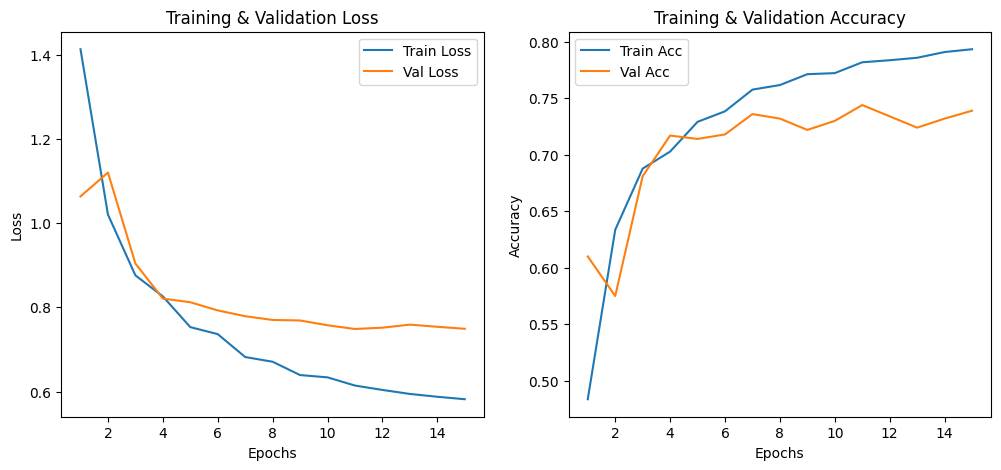

In [17]:
plot_training_history(history)

In [18]:
import json

with open("training_history.json", "w") as f:
    json.dump(history, f)

In [19]:
def evaluate_model(model, dataloader, device='cuda'):
    """
    Collects softmax predictions and true labels for ROC analysis.

    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader for test dataset.
        device: 'cuda' or 'cpu'.

    Returns:
        all_probs: Softmax probabilities of shape (num_samples, num_classes).
        all_labels: True labels of shape (num_samples,).
    """
    criterion = nn.CrossEntropyLoss()
    softmax = nn.Softmax(dim=1)

    model.eval()
    model.to(device)
    test_loss, correct, total = 0, 0, 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for points, features, lorentz_vectors, mask, labels in dataloader:
            points, features, lorentz_vectors, mask, labels = (
                points.to(device),
                features.to(device),
                lorentz_vectors.to(device),
                mask.to(device),
                labels.to(device),
            )

            outputs = model(points, features, lorentz_vectors, mask)

            # Transform one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)

            # Transform logits to probabilities
            probs = softmax(outputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_probs.append(probs.cpu().numpy())  # Convert to numpy
            all_labels.append(labels.cpu().numpy())

    test_acc = correct / total
    print(f"Test Acc: {test_acc:.4f}")
    test_loss /= len(dataloader)
    print(f"Test Loss: {test_loss:.4f}")

    return np.concatenate(all_probs, axis=0), np.concatenate(all_labels, axis=0)

In [20]:
num_classes = len(data_config.label_value)

# Get predictions and true labels
y_probs, y_true = evaluate_model(model, dataloader_test)

# Convert NumPy arrays to lists before saving to JSON
y_probs_list = y_probs.tolist()  # Convert y_probs to a list
y_true_list = y_true.tolist()  # Convert y_true to a list

with open("y_probs.json", "w") as f:
    json.dump(y_probs_list, f)  # Save the list to JSON

with open("y_true.json", "w") as f:
    json.dump(y_true_list, f)  # Save the list to JSON

Test Acc: 0.7558
Test Loss: 0.7174
